# AWS MLE Practice Exam Questions: A Practical Walkthrough

These focus areas are the questions I got incorrect on my latest practice exam attempt. This notebook serves as a hands-on study guide for the AWS Machine Learning Engineer Associate exam. It covers several key concepts identified from practice questions, demonstrating them using Python libraries without directly invoking AWS services. The goal is to understand the underlying principles, which can then be mapped to corresponding AWS tools like SageMaker.

We will follow a narrative simulating parts of an ML project lifecycle:
1.  **Data Preparation:** Addressing class imbalance.
2.  **Feature Management:** Conceptualizing a feature store workflow.
3.  **Modeling:** Choosing appropriate algorithms (XGBoost for classification, RCF-like for anomaly detection), implementing ensembles (Stacking), and preventing overfitting.
4.  **Evaluation & Explainability:** Understanding model predictions (SHAP vs. PDP) and detecting bias (CDD).
5.  **MLOps & Lifecycle:** Conceptualizing pipelines, lineage tracking, and model registries.
6.  **Model Improvement:** Strategies like feature engineering and debugging.

In [5]:
pip install pandas scikit-learn xgboost shap imbalanced-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import RandomOverSampler # Using imblearn for simplicity
import xgboost as xgb
import shap
import time # For early stopping simulation
from IPython.display import display # To display SHAP plots correctly in VS Code notebooks

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully.")

Libraries imported successfully.


## 1. Data Preparation: Handling Class Imbalance (Q50)

**Concept:** Real-world datasets, especially in areas like fraud detection or rare disease prediction, often suffer from class imbalance (one class is much rarer than others). Standard algorithms can become biased towards the majority class. Techniques like oversampling (duplicating minority samples) or undersampling (removing majority samples) are used to create a balanced dataset for training.

**Relation to Practice Question:** I incorrectly identified AWS Glue DataBrew as the primary tool for balancing. While DataBrew is great for general data cleaning, **Amazon SageMaker Data Wrangler** provides specific, built-in transformations like 'Balance Data' (using over/under-sampling techniques like SMOTE or simple duplication) with a user-friendly interface, minimizing operational effort for this specific task. AWS Glue ETL would require custom scripting.

**ML Domain:** Data Preparation for Machine Learning (ML)

**Why it Matters:** Failing to address imbalance can lead to models that perform poorly on the minority class, which is often the class of interest (e.g., detecting fraud).

**AWS Tool:** Amazon SageMaker Data Wrangler (specifically its 'Balance Data' transform).

Original dataset shape: (1000, 20)
Original class distribution:
 target
0    0.95
1    0.05
Name: proportion, dtype: float64


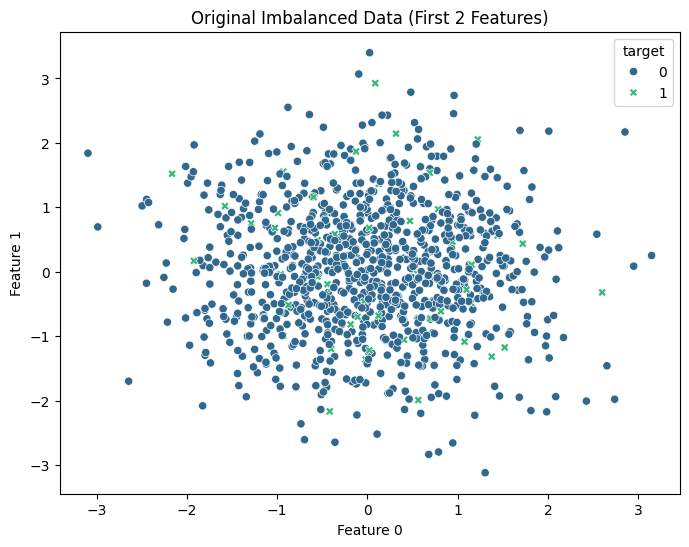


Resampled dataset shape: (1900, 20)
Resampled class distribution:
 target
0    0.5
1    0.5
Name: proportion, dtype: float64


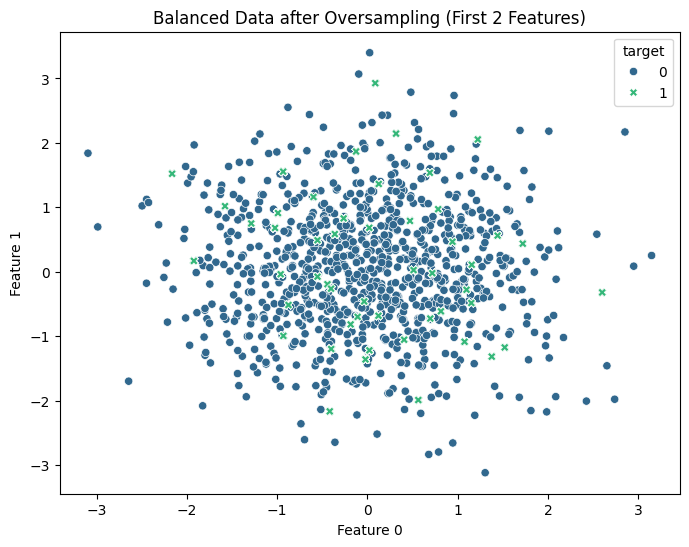


Train set shape: (1520, 20)
Test set shape: (380, 20)
Imbalanced Test set shape: (200, 20)


In [7]:
# --- Generate Imbalanced Data ---
X, y = make_classification(n_samples=1000, n_features=20, n_informative=5,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           weights=[0.95, 0.05], flip_y=0, random_state=42) # 95% class 0, 5% class 1

X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(20)])
y = pd.Series(y, name='target')

print("Original dataset shape:", X.shape)
print("Original class distribution:\n", y.value_counts(normalize=True))

# --- Visualize Imbalance (using first 2 features for simplicity) ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, style=y, palette='viridis')
plt.title('Original Imbalanced Data (First 2 Features)')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

# --- Apply Oversampling (using RandomOverSampler) ---
# This simulates what SageMaker Data Wrangler's "Balance Data" (oversampling) might do.
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("\nResampled dataset shape:", X_resampled.shape)
print("Resampled class distribution:\n", y_resampled.value_counts(normalize=True))

# --- Visualize Balanced Data ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_resampled.iloc[:, 0], y=X_resampled.iloc[:, 1], hue=y_resampled, style=y_resampled, palette='viridis')
plt.title('Balanced Data after Oversampling (First 2 Features)')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

# --- Split data for later use ---
# We'll use the balanced data for most subsequent steps
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# --- Also keep original imbalanced test set for realistic evaluation ---
# Create an imbalanced test set from the *original* data
_, X_test_imb, _, y_test_imb = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print("\nTrain set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Imbalanced Test set shape:", X_test_imb.shape)

## 2. Feature Management: Feature Store Workflow (Q11)

**Concept:** A Feature Store is a centralized repository for storing, managing, retrieving, and sharing curated features for ML training and inference. It promotes consistency, avoids redundant feature engineering work, and facilitates feature discovery. The typical workflow involves:
1.  **Setup:** Defining a 'Feature Group' (schema, unique identifier, event time).
2.  **Ingestion:** Loading (putting) feature data into the Feature Group (often separate online/offline stores).
3.  **Retrieval:** Querying the Feature Store (usually the offline store) to create training/batch datasets or accessing the online store for low-latency inference.

**Relation to Practice Question:** The correct order is crucial: I must first **define the structure (3. Set up Feature Group)**, then **populate it with data (2. Load data)**, and finally **use that data (1. Prepare training dataset)**. My incorrect answer mixed up the loading and setup steps.

**ML Domain:** Data Preparation for Machine Learning (ML)

**Why it Matters:** Ensures feature consistency across teams and models, reduces data leakage, speeds up development, and simplifies feature monitoring.

**AWS Tool:** Amazon SageMaker Feature Store.

**Note:** We won't implement a feature store here, but the concept is vital. Imagine the `X_train`, `X_test` dataframes we created could be generated by querying a feature store after features were defined and ingested.

In [8]:
# --- Inspecting Data (Conceptually Retrieved from Feature Store) ---

print("--- Training Data (Features - X_train) ---")
# Display the first few rows of the feature data prepared for training
display(X_train.head())

print("\n--- Training Data (Target - y_train) ---")
# Display the first few rows of the target variable
display(y_train.head())

print("\n--- Training Data Information ---")
# Display information about the training features DataFrame
X_train.info()

print("\n--- Training Target Distribution ---")
# Check the distribution of the target variable in the training set (should be balanced)
print(y_train.value_counts(normalize=True))

--- Training Data (Features - X_train) ---


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
469,0.537517,-0.945722,-1.022136,-1.056709,-0.539398,1.181563,-0.379794,-0.309191,-1.900490,3.274825,1.047497,-0.466555,2.458877,-0.919627,-0.252049,-0.821160,0.860286,-2.325632,-0.966882,-0.160509
682,0.221568,-0.017747,-0.522853,-0.732901,0.318266,1.330159,-0.294578,0.458099,1.095586,1.440138,-0.913425,-0.362468,1.007362,0.132818,0.459180,-0.798540,-0.899423,0.185491,-0.028850,0.478383
683,-0.180833,0.257238,-0.202523,0.174531,0.230060,-0.979319,-0.213955,0.445792,-1.346141,-0.123087,0.468152,-1.812359,-0.495851,-0.131758,0.100290,0.279316,-2.262374,2.630615,0.728173,0.821548
44,0.431609,1.656115,-0.684459,1.268736,0.787268,-1.849184,1.249595,-2.458406,0.212164,-2.257884,0.596542,0.151635,2.656732,2.247357,1.402546,-0.107205,-0.657352,-0.942575,-0.763357,0.508795
983,1.984921,-0.997251,-0.282807,-0.157722,0.844906,1.705329,-1.563019,-2.054491,0.879297,-1.769604,0.805937,-1.257841,-0.339396,0.428838,-0.982114,0.466749,-2.651791,0.388585,1.746292,0.130230



--- Training Data (Target - y_train) ---


469    0
682    0
683    0
44     0
983    0
Name: target, dtype: int64


--- Training Data Information ---
<class 'pandas.core.frame.DataFrame'>
Index: 1520 entries, 469 to 1864
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_0   1520 non-null   float64
 1   feature_1   1520 non-null   float64
 2   feature_2   1520 non-null   float64
 3   feature_3   1520 non-null   float64
 4   feature_4   1520 non-null   float64
 5   feature_5   1520 non-null   float64
 6   feature_6   1520 non-null   float64
 7   feature_7   1520 non-null   float64
 8   feature_8   1520 non-null   float64
 9   feature_9   1520 non-null   float64
 10  feature_10  1520 non-null   float64
 11  feature_11  1520 non-null   float64
 12  feature_12  1520 non-null   float64
 13  feature_13  1520 non-null   float64
 14  feature_14  1520 non-null   float64
 15  feature_15  1520 non-null   float64
 16  feature_16  1520 non-null   float64
 17  feature_17  1520 non-null   float64
 18  feature_18  1520 non-null   float64


## 3. Modeling

Now we'll explore different modeling aspects based on the practice questions.

### 3.1 Algorithm Choice: Handling Imbalanced Data & Complex Patterns (Q41)

**Concept:** For tasks like fraud detection with structured, potentially imbalanced data, algorithms that handle non-linearities and interactions well are preferred. Gradient Boosted Trees, particularly **XGBoost**, are highly effective. They offer hyperparameters (like `scale_pos_weight`) to explicitly handle class imbalance and allow custom objective functions to optimize for specific metrics (like Precision-Recall AUC) often important in imbalanced scenarios.

**Relation to Q41:** I considered RCF (unsupervised anomaly detection), k-NN (can struggle with high dimensions/large data), and Linear Learner (may not capture complex patterns). XGBoost is generally superior for this type of supervised classification problem due to its robustness, performance, and features for handling imbalance.

**ML Domain:** ML Model Development

**Why it Matters:** Choosing the right algorithm significantly impacts performance, especially with challenging data characteristics. XGBoost often provides a strong baseline or final model for tabular data.

**AWS Tool:** Amazon SageMaker Built-in XGBoost Algorithm.

In [9]:
# --- Scale Data (Good practice for many algorithms, including XGBoost's base learners) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_imb_scaled = scaler.transform(X_test_imb) # Scale the imbalanced test set too

# --- Train XGBoost Model ---
# Calculate scale_pos_weight for imbalance (though we trained on balanced data, this shows the parameter)
# scale_pos_weight = count(negative examples) / count(positive examples)
# Using original data counts: scale_pos_weight = (y == 0).sum() / (y == 1).sum()
# Since we used RandomOverSampler, our training data is balanced (scale_pos_weight approx 1)
# If training on imbalanced data, this parameter is crucial.

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42) # scale_pos_weight=scale_pos_weight could be added if needed

print("Training XGBoost model...")
xgb_model.fit(X_train_scaled, y_train)

# --- Evaluate on the original imbalanced test set for a realistic view ---
print("\n--- XGBoost Evaluation on Imbalanced Test Set ---")
y_pred_xgb_imb = xgb_model.predict(X_test_imb_scaled)
y_proba_xgb_imb = xgb_model.predict_proba(X_test_imb_scaled)[:, 1]

print(classification_report(y_test_imb, y_pred_xgb_imb))
print(f"AUC Score: {roc_auc_score(y_test_imb, y_proba_xgb_imb):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test_imb, y_pred_xgb_imb))

Training XGBoost model...

--- XGBoost Evaluation on Imbalanced Test Set ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       190
           1       0.91      1.00      0.95        10

    accuracy                           0.99       200
   macro avg       0.95      1.00      0.97       200
weighted avg       1.00      0.99      1.00       200

AUC Score: 1.0000
Confusion Matrix:
 [[189   1]
 [  0  10]]


c:\Users\phili\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:05:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### 3.2 Algorithm Choice: Anomaly Detection for Predictive Maintenance (Q23)

**Concept:** Predictive maintenance often involves identifying unusual patterns or outliers in sensor data that precede equipment failure. **Anomaly detection algorithms** are suited for this. Random Cut Forest (RCF) is an unsupervised algorithm that isolates anomalies by randomly partitioning the data space. Anomalous points are typically easier to isolate and require fewer partitions.

**Relation to Q23:** I considered Linear Learner (classification), DeepAR (time series *forecasting*), and Time Series K-Means (clustering). While these might play a role in a broader solution, **RCF** directly addresses the core need: detecting *anomalies* that signal potential failure.

**ML Domain:** ML Model Development

**Why it Matters:** Identifying anomalies early allows for proactive maintenance, preventing costly downtime. Unsupervised methods like RCF are useful when labeled failure data is scarce.

**AWS Tool:** Amazon SageMaker Random Cut Forest (RCF) Algorithm.

**Note:** We'll use Scikit-learn's `IsolationForest`, which is conceptually similar to RCF (both use tree-based isolation).

Training Isolation Forest...


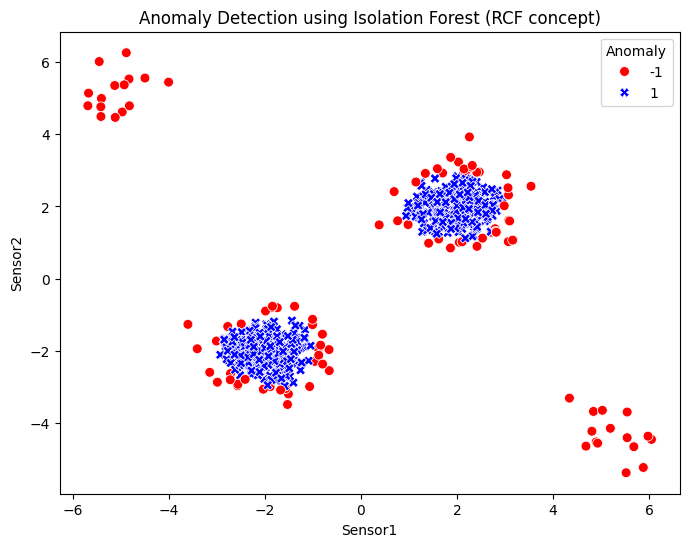


Number of detected anomalies: 101


In [10]:
# --- Generate Sample Data with Anomalies ---
# Create some normal data points (cluster 1)
X_normal, _ = make_blobs(n_samples=300, centers=[[2, 2]], cluster_std=0.5, random_state=42)
# Create some different normal data points (cluster 2)
X_normal2, _ = make_blobs(n_samples=300, centers=[[-2, -2]], cluster_std=0.5, random_state=10)
# Create some anomalies far from the clusters
X_anomalies, _ = make_blobs(n_samples=30, centers=[[5, -4], [-5, 5]], cluster_std=0.6, random_state=1)

X_anomaly_data = np.vstack((X_normal, X_normal2, X_anomalies))
X_anomaly_data = pd.DataFrame(X_anomaly_data, columns=['Sensor1', 'Sensor2'])

# --- Train Isolation Forest ---
# `contamination` is the expected proportion of outliers, similar to RCF's `num_samples_per_tree` influences sensitivity
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42) # 'auto' estimates contamination

print("Training Isolation Forest...")
iso_forest.fit(X_anomaly_data)

# --- Predict Anomalies (-1 for anomalies, 1 for inliers) ---
y_pred_anomaly = iso_forest.predict(X_anomaly_data)
X_anomaly_data['Anomaly'] = y_pred_anomaly

# --- Visualize Anomalies ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X_anomaly_data, x='Sensor1', y='Sensor2', hue='Anomaly', style='Anomaly', palette={1: 'blue', -1: 'red'}, s=50)
plt.title('Anomaly Detection using Isolation Forest (RCF concept)')
plt.show()

print("\nNumber of detected anomalies:", (X_anomaly_data['Anomaly'] == -1).sum())

### 3.3 Ensemble Methods: Stacking (Q5)

**Concept:** Ensemble methods combine multiple models to improve overall performance and robustness.
*   **Bagging:** Trains the *same* base model type on different subsets of data (e.g., Random Forest). Reduces variance.
*   **Boosting:** Trains models sequentially, with each correcting the errors of the previous ones (e.g., XGBoost, AdaBoost). Reduces bias.
*   **Voting:** Simple combination by majority vote (classification) or averaging (regression).
*   **Stacking:** Trains multiple *different* base models. Their predictions are then used as input features for a final 'meta-model' which makes the ultimate prediction. Leverages the diverse strengths of various algorithms.

**Relation to Q5:** I was asked how to combine *different* models (Logistic Regression, Decision Tree, SVM) effectively. Stacking is the most appropriate answer because it explicitly uses the outputs of these diverse base learners as inputs to a meta-learner, learning how to best combine their predictions. Bagging/Boosting usually use the same base learner type. Simple voting doesn't learn optimal weights like a meta-model does.

**ML Domain:** ML Model Development

**Why it Matters:** Stacking can often achieve better performance than any single model by combining diverse perspectives on the data.

**AWS Tool:** While SageMaker doesn't have a built-in "Stacking" algorithm, you can implement it using SageMaker Training Jobs for base learners and another for the meta-learner, or by using SageMaker Pipelines to orchestrate the process. Custom containers can also be used. SageMaker supports deploying multi-container or serial inference pipelines which can host ensemble models.

In [11]:
# --- Define Base Models ---
estimators = [
    ('lr', LogisticRegression(random_state=42, max_iter=1000)),
    ('dt', DecisionTreeClassifier(random_state=42, max_depth=5)),
    ('svc', SVC(probability=True, random_state=42)) # Need probability=True for stacking meta-learner
]

# --- Define Meta-Model ---
# Often a relatively simple but robust model like Logistic Regression or RandomForest
meta_learner = RandomForestClassifier(n_estimators=50, random_state=42)

# --- Create Stacking Classifier ---
# cv=5 means predictions for the meta-learner are generated using 5-fold cross-validation on the training data
stacking_model = StackingClassifier(estimators=estimators, final_estimator=meta_learner, cv=5)

print("Training Stacking model...")
# Use the scaled balanced data
stacking_model.fit(X_train_scaled, y_train)

# --- Evaluate Stacking Model on Imbalanced Test Set ---
print("\n--- Stacking Model Evaluation on Imbalanced Test Set ---")
y_pred_stack_imb = stacking_model.predict(X_test_imb_scaled)
y_proba_stack_imb = stacking_model.predict_proba(X_test_imb_scaled)[:, 1]

print(classification_report(y_test_imb, y_pred_stack_imb))
print(f"AUC Score: {roc_auc_score(y_test_imb, y_proba_stack_imb):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test_imb, y_pred_stack_imb))

# Compare with a base model (e.g., Logistic Regression)
print("\n--- Logistic Regression (Base Model) Evaluation on Imbalanced Test Set ---")
base_lr = LogisticRegression(random_state=42, max_iter=1000).fit(X_train_scaled, y_train)
y_pred_lr_imb = base_lr.predict(X_test_imb_scaled)
y_proba_lr_imb = base_lr.predict_proba(X_test_imb_scaled)[:, 1]
print(classification_report(y_test_imb, y_pred_lr_imb))
print(f"AUC Score: {roc_auc_score(y_test_imb, y_proba_lr_imb):.4f}")

Training Stacking model...

--- Stacking Model Evaluation on Imbalanced Test Set ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       190
           1       1.00      1.00      1.00        10

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

AUC Score: 1.0000
Confusion Matrix:
 [[190   0]
 [  0  10]]

--- Logistic Regression (Base Model) Evaluation on Imbalanced Test Set ---
              precision    recall  f1-score   support

           0       0.99      0.84      0.91       190
           1       0.21      0.80      0.33        10

    accuracy                           0.83       200
   macro avg       0.60      0.82      0.62       200
weighted avg       0.95      0.83      0.88       200

AUC Score: 0.9011


### 3.4 Preventing Overfitting (Q56)

**Concept:** Overfitting occurs when a model learns the training data too well, including noise, and fails to generalize to new, unseen data. Common techniques include:
*   **Data Augmentation:** Artificially increasing training data size/diversity (esp. for images: rotations, flips, brightness changes).
*   **Regularization (L1/L2):** Adding penalties to the loss function based on model weights to discourage complexity.
*   **Dropout:** Randomly dropping neurons during training (for neural networks) to prevent co-dependency.
*   **Early Stopping:** Monitoring performance on a validation set during training and stopping when performance stops improving.
*   **Pruning:** Removing parts of a model (e.g., tree branches, network nodes) post-training.
*   **Ensembling:** Combining multiple models (as seen with Stacking) often improves generalization.

**Relation to Q56:** The question involved a deep learning model overfitting on limited medical image data. The BEST combination often involves attacking the problem from multiple angles: **Data Augmentation** (addresses limited data), **Early Stopping** (prevents over-training), and **Ensembling** (improves robustness). While dropout and regularization are valid, they might not be sufficient alone, especially with severe data limitations. Pruning is usually done after training.

**ML Domain:** ML Model Development

**Why it Matters:** Overfitting leads to models that are useless in practice. Preventing it is crucial for building reliable ML systems.

**AWS Tool:** SageMaker Training jobs support early stopping. Data augmentation can be done in preprocessing scripts or using libraries within the training script. Ensembling can be implemented as described before. Regularization/Dropout are often built into algorithm hyperparameters (e.g., SageMaker's built-in algos, deep learning frameworks).

In [14]:
# --- Simulate Overfitting with a Complex Decision Tree ---
# Use a small subset of the balanced data to encourage overfitting
X_train_small, _, y_train_small, _ = train_test_split(X_train_scaled, y_train, train_size=0.1, random_state=42, stratify=y_train)

overfit_tree = DecisionTreeClassifier(random_state=42) # No depth limit
overfit_tree.fit(X_train_small, y_train_small)

train_acc = accuracy_score(y_train_small, overfit_tree.predict(X_train_small))
# Evaluate on the full (original imbalanced) test set
test_acc = accuracy_score(y_test_imb, overfit_tree.predict(X_test_imb_scaled))

print(f"Overfit Tree Train Accuracy: {train_acc:.4f}")
print(f"Overfit Tree Test Accuracy (Imbalanced): {test_acc:.4f}") # Expect a large gap

# --- Simulate Early Stopping (Conceptual Example) ---
# We don't have epochs here like DL, but can simulate by checking validation score vs complexity (e.g., tree depth)
# This requires a validation set separate from the test set
X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train)

best_val_score = -1
best_depth = -1
patience_counter = 0 # Initialize patience counter
print("\nSimulating Early Stopping by Tree Depth:")
for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train_es, y_train_es)
    val_score = roc_auc_score(y_val_es, model.predict_proba(X_val_es)[:, 1])
    print(f"Depth: {depth}, Validation AUC: {val_score:.4f}")
    # Simple early stopping: stop if score doesn't improve for 'patience' steps (here, patience=3)
    if val_score > best_val_score:
        best_val_score = val_score
        best_depth = depth
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 3:
            print(f"Stopping early at depth {depth} (Best validation AUC {best_val_score:.4f} achieved at depth {best_depth})")
            break
# Handle case where loop finishes without early stopping
if patience_counter < 3:
    print(f"Loop finished. Best validation AUC {best_val_score:.4f} at depth {best_depth}.")


# --- Train model with 'best' hyperparameter found via early stopping ---
early_stopped_tree = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
early_stopped_tree.fit(X_train_scaled, y_train) # Retrain on full training data

train_acc_es = accuracy_score(y_train, early_stopped_tree.predict(X_train_scaled))
test_acc_es = accuracy_score(y_test_imb, early_stopped_tree.predict(X_test_imb_scaled))
test_auc_es = roc_auc_score(y_test_imb, early_stopped_tree.predict_proba(X_test_imb_scaled)[:,1])

print(f"\nEarly Stopped Tree (Depth {best_depth}) Train Accuracy: {train_acc_es:.4f}")
print(f"Early Stopped Tree Test Accuracy (Imbalanced): {test_acc_es:.4f}")
print(f"Early Stopped Tree Test AUC (Imbalanced): {test_auc_es:.4f}") # Likely better generalization than the overfit tree

# --- Data Augmentation & Ensembling ---
# Data Augmentation: Conceptually, for image data, this would involve creating modified copies (rotated, flipped, etc.). For tabular data, techniques like SMOTE (Synthetic Minority Over-sampling Technique) are sometimes considered augmentation. We already did random oversampling.
# Ensembling: Our Stacking model (Section 3.3) is an example of ensembling that helps generalization.

Overfit Tree Train Accuracy: 1.0000
Overfit Tree Test Accuracy (Imbalanced): 0.8950

Simulating Early Stopping by Tree Depth:
Depth: 1, Validation AUC: 0.7434
Depth: 2, Validation AUC: 0.8937
Depth: 3, Validation AUC: 0.9459
Depth: 4, Validation AUC: 0.9783
Depth: 5, Validation AUC: 0.9898
Depth: 6, Validation AUC: 0.9895
Depth: 7, Validation AUC: 0.9897
Depth: 8, Validation AUC: 0.9901
Depth: 9, Validation AUC: 0.9901
Depth: 10, Validation AUC: 0.9901
Depth: 11, Validation AUC: 0.9901
Stopping early at depth 11 (Best validation AUC 0.9901 achieved at depth 8)

Early Stopped Tree (Depth 8) Train Accuracy: 0.9993
Early Stopped Tree Test Accuracy (Imbalanced): 0.9700
Early Stopped Tree Test AUC (Imbalanced): 0.9842


## 4. Evaluation & Explainability

### 4.1 Model Explainability: SHAP vs. Partial Dependence Plots (PDP) (Q43)

**Concept:** Understanding *why* a model makes certain predictions is crucial for trust, debugging, and compliance.
*   **SHAP (SHapley Additive exPlanations):** A game theory approach that assigns an 'importance value' to each feature for a *specific prediction* (local explanation). It explains how much each feature contributed to pushing the prediction away from the average prediction. Averaging SHAP values across many instances gives global feature importance.
*   **Partial Dependence Plots (PDP):** Shows the marginal effect of one or two features on the predicted outcome of a model, averaging out the effects of all other features (global explanation). It helps visualize the relationship between a feature and the prediction across the dataset.

**Relation to Q43:** I confused local and global explanations. **SHAP provides local explanations** (why this *specific* customer got this prediction), although it can be aggregated globally. **PDP provides global explanations** (how does 'income', on average, affect predictions across *all* customers).

**ML Domain:** ML Model Development

**Why it Matters:** Explainability builds trust, helps identify bias, ensures regulatory compliance (like explaining loan decisions), and aids model debugging.

**AWS Tool:** Amazon SageMaker Clarify integrates SHAP for local/global explanations and also provides PDP capabilities.


--- SHAP Local Explanation (Instance 0) ---



--- SHAP Global Explanation (Feature Importance) ---


C:\Users\phili\AppData\Local\Temp\ipykernel_15116\3238359810.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled_df, show=False)


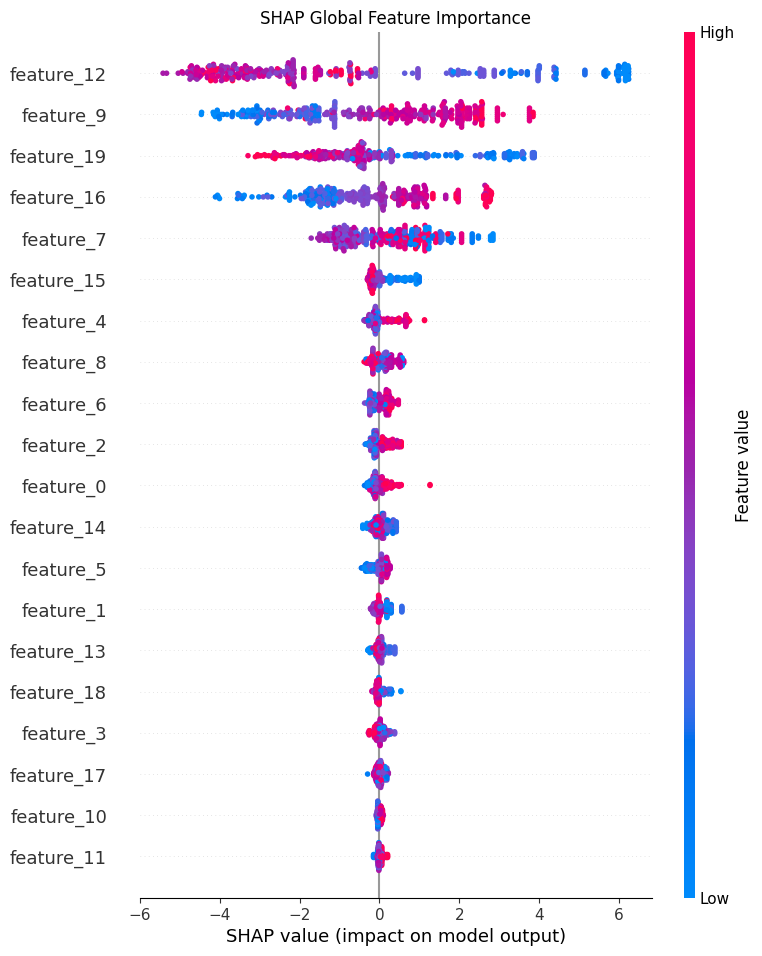


--- PDP Global Explanation (Top 2 Features: ['feature_12', 'feature_9']) ---


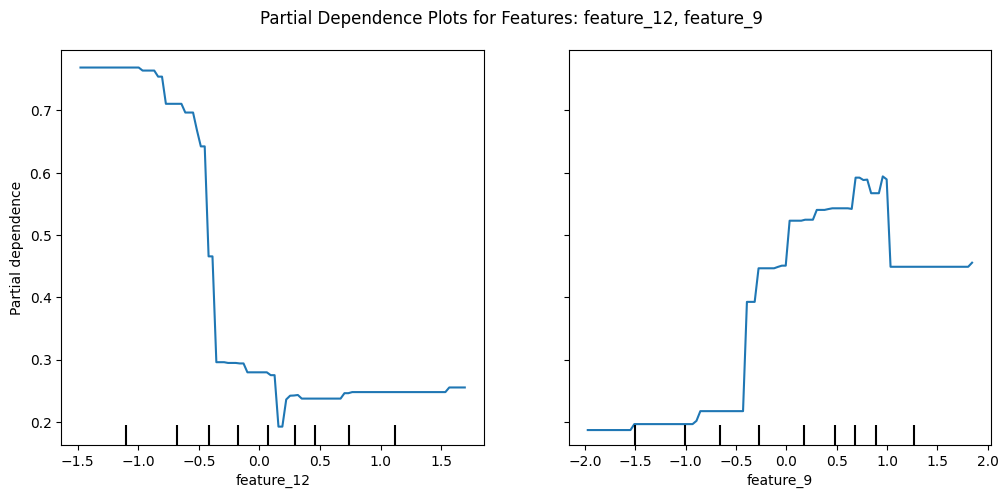

In [16]:
# --- Use the trained XGBoost model ---
# Ensure data passed to explainer is the same format as training data (numpy array here)
explainer = shap.TreeExplainer(xgb_model, X_train_scaled)
# Ensure data passed for SHAP values is also the same format
shap_values = explainer.shap_values(X_test_scaled)

# Convert scaled test data back to DataFrame for feature names in plots
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# --- Local Explanation (SHAP Force Plot for one instance) ---
instance_index = 0 # Explain the first instance in the test set
print(f"\n--- SHAP Local Explanation (Instance {instance_index}) ---")
# Use the DataFrame version for feature names display
display(shap.force_plot(explainer.expected_value, shap_values[instance_index,:], X_test_scaled_df.iloc[instance_index,:]))

# --- Global Explanation (SHAP Summary Plot) ---
print("\n--- SHAP Global Explanation (Feature Importance) ---")
shap.summary_plot(shap_values, X_test_scaled_df, show=False)
plt.title("SHAP Global Feature Importance")
plt.show()

# --- Global Explanation (Partial Dependence Plot - PDP) ---
# Let's look at the top 2 features from SHAP summary plot
# Note: SHAP plot might reorder features, manually check the plot output for top features
# Need to get feature indices based on importance from SHAP values
feature_importance_order = np.argsort(np.abs(shap_values).mean(0))[::-1]
top_features_indices = feature_importance_order[:2]
top_features_names = X_test_scaled_df.columns[top_features_indices].tolist()

print(f"\n--- PDP Global Explanation (Top 2 Features: {top_features_names}) ---")

fig, ax = plt.subplots(figsize=(12, 5)) # Adjusted figure size
try:
    display_pdp = PartialDependenceDisplay.from_estimator(
        xgb_model,
        X_test_scaled, # Use the numpy array here as expected by from_estimator
        features=top_features_indices, # Indices of features
        feature_names=X_test_scaled_df.columns.tolist(), # Original feature names for labeling
        ax=ax
    )
    plt.suptitle(f"Partial Dependence Plots for Features: {', '.join(top_features_names)}")
    plt.subplots_adjust(top=0.9) # Adjust title position
    plt.show()
except Exception as e:
    print(f"Could not generate PDP plot: {e}") # Add error handling
    # Common issue: Categorical features if not handled correctly before scaling/modeling

### 4.2 Bias Detection: Conditional Demographic Disparity (CDD) (Q57)

**Concept:** Ensuring fairness in ML models is critical, especially in sensitive applications. Bias metrics help quantify disparities in model performance or predictions across different demographic groups (e.g., race, gender). **Conditional Demographic Disparity (CDD)** specifically measures the disparity in *positive prediction rates* between demographic groups *after conditioning* on a legitimate factor (attribute). For example, comparing loan approval rates between two demographic groups *within the same income bracket*.

**Relation to Q57:** I was asked how CDD assesses bias. The key is the **conditioning** aspect. It doesn't just look at overall approval rates (which might differ legitimately due to factors like income), but checks if disparities *persist* even when controlling for such factors. It focuses on *prediction rates*, not accuracy or feature importance directly.

**ML Domain:** ML Model Development (Fairness and Bias)

**Why it Matters:** Helps identify subtle biases that might be masked by confounding variables, leading to fairer and more equitable models.

**AWS Tool:** Amazon SageMaker Clarify calculates various bias metrics, including pre-training (data) bias metrics like CDD and post-training (model) bias metrics.

**Note:** Calculating CDD requires demographic information and conditioning attributes, which we don't have in our synthetic dataset. The explanation focuses on the concept. Imagine adding 'income_bracket' and 'demographic_group' columns to our data. CDD would compare `P(Predicted_Positive | demographic=A, income=X)` vs `P(Predicted_Positive | demographic=B, income=X)`.

## 5. MLOps & Lifecycle Management

These concepts are about managing the ML process systematically.

### 5.1 Orchestration, Lineage, and Governance (Q25)

**Concept:**
*   **Orchestration:** Automating and managing the sequence of steps in an ML workflow (data prep, training, evaluation, deployment) often visualized as a Directed Acyclic Graph (DAG).
*   **Lineage Tracking:** Automatically recording the relationships between workflow steps, datasets, code, models, and deployments for reproducibility, debugging, and auditing.
*   **Governance:** Ensuring models meet regulatory requirements, ethical standards, and business policies, often relying on lineage tracking and documentation.

**Relation to Q25:** The scenario required granular control, DAG visualization, history/reproducibility, and governance/auditing. **SageMaker Pipelines** provides ML-specific orchestration with DAG visualization. **SageMaker ML Lineage Tracking** automatically captures detailed relationships between artifacts and steps, crucial for auditing and compliance. SageMaker Experiments tracks *trials* within steps but isn't the primary tool for end-to-end lineage or governance. AWS CodePipeline is a general CI/CD tool, less tailored for ML specifics like DAGs and fine-grained ML step control.

**ML Domain:** ML Solution Monitoring, Maintenance, and Security

**Why it Matters:** MLOps practices ensure ML workflows are reliable, reproducible, auditable, and easier to manage at scale.

**AWS Tools:** Amazon SageMaker Pipelines, Amazon SageMaker ML Lineage Tracking.

**Note:** No code here, this is about understanding the purpose of these SageMaker components.

### 5.2 Model Registry (Q10)

**Concept:** A centralized system for storing, versioning, organizing, and managing trained ML models. It typically stores model artifacts, metadata (metrics, parameters), lineage information, and approval status, facilitating controlled deployment.

**Relation to Q10:** The requirements were secure data access (handled by SageMaker/IAM generally), a centralized registry for versioning/deployment with minimal overhead. **SageMaker Model Registry** is purpose-built for this in the SageMaker ecosystem. It allows organizing models into 'Model Groups' and versioning them, integrating with deployment workflows. Using S3 versioning alone is manual and lacks ML-specific metadata/governance. ECR stores container images, not model artifacts directly in a registry format. Tags are insufficient for robust versioning and management.

**ML Domain:** ML Solution Monitoring, Maintenance, and Security

**Why it Matters:** Provides control over which model versions are deployed, enables rollbacks, ensures traceability, and simplifies model governance.

**AWS Tool:** Amazon SageMaker Model Registry.

**Note:** No code here. Imagine after training our `xgb_model` or `stacking_model`, we would register its artifacts (e.g., the saved model file) and performance metrics (`AUC`, `classification_report`) into the Model Registry before deploying it.

## 6. Model Improvement Strategies (Q62)

**Concept:** When a deployed model underperforms (e.g., low AUC), several strategies can be employed:
*   **Feature Engineering:** Creating new, more informative features from existing data. Often highly impactful, especially with domain knowledge.
*   **Debugging Training:** Identifying issues like vanishing/exploding gradients, saturated activations, or overfitting during the training process itself.
*   **Hyperparameter Tuning (HPT):** Systematically searching for the optimal set of hyperparameters for an algorithm (e.g., learning rate, tree depth).
*   **More Data:** Acquiring more *real* data is often best. Synthetic data can help but carries risks.
*   **Different Algorithms:** Trying fundamentally different modeling approaches.

**Relation to Q62:** The question asked for the *most likely* impactful strategies given underperformance (low AUC) and limited resources. **Feature Engineering** often yields significant gains by improving the information available to the model. **Debugging the training process** (using tools like SageMaker Debugger) can uncover fundamental issues hindering performance (like gradients vanishing). While HPT is valuable, its impact might be limited if the features are poor or the training process is flawed. Switching to complex models or relying solely on synthetic data might not be the most efficient first steps.

**ML Domain:** ML Model Development

**Why it Matters:** Model improvement is an iterative process. Knowing which strategies to prioritize saves time and resources.

**AWS Tools:** Amazon SageMaker Clarify (for feature importance to guide engineering), Amazon SageMaker Debugger (for diagnosing training issues), Amazon SageMaker Automatic Model Tuning (for HPT).

**Note:** We already performed some feature scaling and used XGBoost (a powerful algorithm). Let's conceptually add a simple interaction feature to demonstrate feature engineering.

In [17]:
# --- Feature Engineering Example ---
# Create an interaction feature (product of two existing features)
# Let's use the top 2 features identified by SHAP earlier (e.g., indices from top_features_indices)
# Important: Apply this to train and test sets consistently!

# Create copies to avoid modifying original scaled data used elsewhere
X_train_fe = pd.DataFrame(X_train_scaled, columns=X_train.columns).copy()
X_test_fe = pd.DataFrame(X_test_scaled, columns=X_test.columns).copy()
X_test_imb_fe = pd.DataFrame(X_test_imb_scaled, columns=X_test_imb.columns).copy()


# Use the indices found previously
if 'top_features_indices' in locals() and len(top_features_indices) >= 2:
    feat1_idx = top_features_indices[0]
    feat2_idx = top_features_indices[1]
    feat1_name = X_train.columns[feat1_idx]
    feat2_name = X_train.columns[feat2_idx]
    interaction_name = f"{feat1_name}_x_{feat2_name}"

    X_train_fe[interaction_name] = X_train_fe.iloc[:, feat1_idx] * X_train_fe.iloc[:, feat2_idx]
    X_test_fe[interaction_name] = X_test_fe.iloc[:, feat1_idx] * X_test_fe.iloc[:, feat2_idx]
    X_test_imb_fe[interaction_name] = X_test_imb_fe.iloc[:, feat1_idx] * X_test_imb_fe.iloc[:, feat2_idx]

    print("Shape before Feature Engineering:", X_train_scaled.shape)
    print("Shape after Feature Engineering:", X_train_fe.shape)
    print("New feature added:", interaction_name)

    # --- Retrain XGBoost with new feature ---
    xgb_model_fe = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

    print("\nTraining XGBoost model with added feature...")
    xgb_model_fe.fit(X_train_fe, y_train) # Use the dataframe with the new feature

    # --- Evaluate on Imbalanced Test Set with new feature ---
    print("\n--- XGBoost FE Evaluation on Imbalanced Test Set ---")
    y_pred_xgb_fe_imb = xgb_model_fe.predict(X_test_imb_fe)
    y_proba_xgb_fe_imb = xgb_model_fe.predict_proba(X_test_imb_fe)[:, 1]

    print(classification_report(y_test_imb, y_pred_xgb_fe_imb))
    print(f"AUC Score: {roc_auc_score(y_test_imb, y_proba_xgb_fe_imb):.4f}") # Compare this AUC to the previous XGBoost AUC
    print("Confusion Matrix:\n", confusion_matrix(y_test_imb, y_pred_xgb_fe_imb))
else:
    print("Could not perform feature engineering step - top features not determined from SHAP/PDP.")


# --- Debugging (Conceptual) ---
# SageMaker Debugger would hook into the training loop (especially for DL or complex algos)
# It monitors tensors (like gradients, weights, activations, loss) in real-time.
# You define Rules (e.g., VanishingGradient, ExplodingTensor, Overfitting)
# If a rule triggers, it can stop the job or log detailed information.
# Example: If gradients become consistently near zero, the VanishingGradient rule triggers,
# suggesting potential issues with network architecture or activation functions.

Shape before Feature Engineering: (1520, 20)
Shape after Feature Engineering: (1520, 21)
New feature added: feature_12_x_feature_9

Training XGBoost model with added feature...

--- XGBoost FE Evaluation on Imbalanced Test Set ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       190
           1       0.91      1.00      0.95        10

    accuracy                           0.99       200
   macro avg       0.95      1.00      0.97       200
weighted avg       1.00      0.99      1.00       200

AUC Score: 1.0000
Confusion Matrix:
 [[189   1]
 [  0  10]]


c:\Users\phili\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:48:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Conclusion

This notebook walked through several key concepts relevant to the AWS MLE exam, using practical Python examples:

*   **Data Prep:** Handled class imbalance using oversampling (like SageMaker Data Wrangler).
*   **Feature Store:** Understood the conceptual workflow (like SageMaker Feature Store).
*   **Modeling:**
    *   Chose XGBoost for imbalanced classification (like SageMaker XGBoost).
    *   Used Isolation Forest for anomaly detection (like SageMaker RCF).
    *   Implemented Stacking ensembles.
    *   Applied techniques like early stopping to prevent overfitting.
*   **Evaluation & Explainability:** Differentiated local (SHAP) and global (PDP) explanations and understood conditional bias metrics (CDD) (like SageMaker Clarify).
*   **MLOps:** Conceptualized orchestration (Pipelines), lineage tracking, and model registries (like SageMaker Pipelines, Lineage Tracking, Model Registry).
*   **Improvement:** Demonstrated feature engineering and discussed debugging (like SageMaker Debugger).

By understanding these underlying ML principles and how they map to specific AWS services, you'll be better prepared for the scenarios presented in the exam. Remember to focus not just on *what* the services do, but *why* and *when* you would choose one over another based on the ML problem and requirements. Good luck with your studies!